# Tutorial 9

## Q-Learning

Recall the Bellman equations for

1. Value function: $V^{\pi}(s) = \max_{a \in \mathcal{A}} \mathbb{E} \bigg[ r(a,s,s') + \gamma V^{\pi}(s') \bigg]$
2. Q-function: $Q^{\pi}(s,a) = \mathbb{E} \bigg[ r(a,s,s') + \gamma \max_{a' \in \mathcal{A}} Q^{\pi}(s',a') \bigg]$

#### Example: Q-learning algorithm

This example comes from Sebastian Jaimungal on a small Markov decision process (MDP).

In [1]:
# load Python libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

We can either define our own environment, or use a pre-defined environment. Any environment class must contain a `__init__` function to initialize the parameters, a `reset()` function to obtain the initial state (with finite horizon problems), and a `step()` function to move from one state to another.

In [2]:
class Environment():
    # constructor
    def __init__(self, A, r):
        self.A = A # transition probabilities
        self.r = r # reward function
    
    # evolution of the environment
    def step(self, s, a):
        s_prime = np.sum(np.random.rand() >= np.cumsum(self.A[s,:]))
        reward = self.r[s, s_prime, a]
        
        return s_prime, reward

All functions for the training algorithm are usually grouped into a single class.

In [29]:
class Qlearning():
    # constructor
    def __init__(self, env : Environment, gamma=0.99):
        
        self.env = env # environment
        
        self.Q = np.random.randn(self.env.r.shape[0], self.env.r.shape[2])
        
        self.Q_hist = [] # evolution of the Q value(s)
        self.pi_hist = [] # evolution of the policy
        
        self.gamma = gamma # discount factor
        
        self.GreedyPolicyUpdate()
    
    # update the policy (in a greedy manner) using the Q function estimate
    def GreedyPolicyUpdate(self):
        
        pi = np.zeros(self.Q.shape[0], int)
        
        for s in range(self.env.r.shape[0]):
            pi[s] = np.argmax( self.Q[s,:] )
            
        self.pi = pi
    
    # evaluate the policy
    def PolicyEvaluation(self, n_iter=10):
        
        # initialize the tables of transitions
        s = np.zeros(n_iter, int)
        a = np.zeros(n_iter, int)
        sp = np.zeros(n_iter, int)
        r = np.zeros(n_iter, int)
        
        C = 400
        D = 500
        
        for i in range(n_iter-1):
            
            # decay the learning rate and epsilon
            alpha = C/(D+self.count)
            epsilon = C/(D+self.count)
            
            # action taken from state s_t, epsilon-greedy as exploratory policy
            if np.random.rand() < epsilon:
                a[i] = int( np.random.randint(self.env.r.shape[2]) )
            else:
                a[i] = self.pi[s[i]] 
                
            # run the action in the environment and get new state and reward
            sp[i], r[i] = self.env.step(s[i], a[i])
            
            Qp = self.Q.copy()
            
            # compute Q target
            ap = np.argmax(self.Q[sp[i],:])
            Q_target = r[i] + self.gamma*self.Q[sp[i], ap]
            
            # update Q table
            Qp[s[i],a[i]] = self.Q[s[i],a[i]] + alpha*( Q_target - self.Q[s[i],a[i]] )
            self.Q = Qp
            
            # update current state
            s[i+1] = sp[i]
            
            self.count += 1
            
    # run the whole algorithm    
    def Run(self, n_iter=1_000):
        
        # count the number of steps run in the algorithm
        self.count = 0
        
        for i in tqdm(range(n_iter)):
            
            self.Q_hist.append(1.0*self.Q)
            self.PolicyEvaluation(n_iter=100)
            
            self.pi_hist.append(1.0*self.pi)
            self.GreedyPolicyUpdate()
        
        fig, axes = plt.subplots(1, 3, figsize=(14,8), sharex=True)
                
        axes[0].plot(np.max(np.array(self.Q_hist), axis=1))
        axes[0].set_title(r"$V_t$")

        axes[1].plot(np.array(self.pi_hist))
        axes[1].set_title(r"$\pi_t$")

        axes[2].plot(np.array(self.Q_hist).reshape(-1,6))
        axes[2].set_ylim(55,65)
        axes[2].set_title(r"$Q_t$")
        axes[2].legend([r"$s=0, a=0$",
                       r"$s=0, a=1$",
                       r"$s=0, a=2$",
                       r"$s=1, a=0$",
                       r"$s=1, a=1$",
                       r"$s=1, a=2$"], fontsize=16)

        plt.tight_layout()
        plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 265.45it/s]


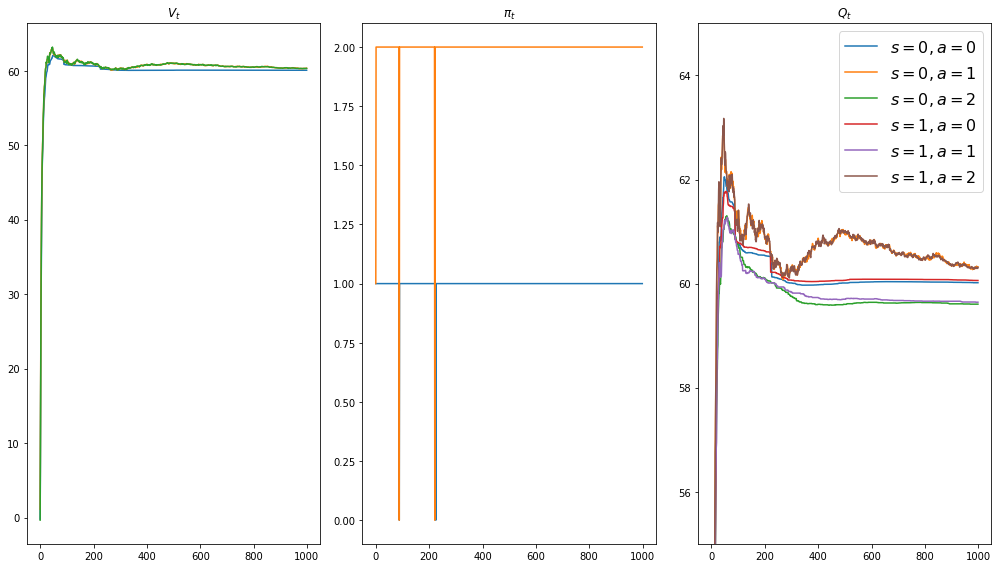

In [31]:
A = np.array([[0.4, 0.6],[0.6, 0.4]])

# axis 0 = state
# axis 1 = state'
# axis 2 = action
r = np.zeros((2,2,3))

# down, down
r[0,0,:] = 0  # price stayed down, all actions have zero value

# down, up
r[0,1,0] = 0   # do nothing
r[0,1,1] = +1   # hold long position
r[0,1,2] = -1  # hold short position

# up, down
r[1,0,0] = 0   # do nothing
r[1,0,1] = -1   # hold long position
r[1,0,2] = +1  # hold short position

# up, up
r[1,1,:] = 0 # all actions have zero reward

env = Environment(A, r)

#%%
model = Qlearning(env)
model.Run(n_iter = 1000)